# DSCI 573 - Feature and Model Selection

## Lecture 4: Feature importances and feature selection 

UBC Master of Data Science program, 2019-20

Instructor: Varada Kolhatkar

## Learning outcomes 

From this lecture, students are expected to be able to:

- Interpret the coefficients of linear regression, including for scaled numeric variables. 
- Explain the general concept of feature selection. 
- Discuss and compare different feature selection methods at a high level. 
- Use `sklearn`'s implementation of recursive feature elimination (`RFE`). 
- Implement the forward search algorithm. 
- Relate feature selection to the idea of complexity penalty. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

import seaborn as sns

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## 1. Data 

- Video 1

In this lecture, we'll be using [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/), the dataset we used in lecture 2. As usual, to run this notebook you'll need to download the data. Unzip the data into a subdirectory called `data`. For this dataset, train and test have already been separated. We'll be working with the train portion in this lecture. 

In [3]:
df = pd.read_csv("data/housing-kaggle/train.csv")
train_df, test_df = train_test_split(df, test_size = 0.10, random_state=123)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
302,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
767,768,50,RL,75.0,12508,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,1300,7,2008,WD,Normal,160000
429,430,20,RL,130.0,11457,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,175000
1139,1140,30,RL,98.0,8731,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,144000
558,559,60,RL,57.0,21872,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,175000


- The prediction task is predicting `SalePrice` given features related to properties.  
- Note that the target is numeric, not categorical.

In [4]:
train_df.shape

(1314, 81)

### Let's separate `X` and `y`

In [5]:
X_train = train_df.drop(columns=['SalePrice'])
y_train = train_df['SalePrice']

X_test = test_df.drop(columns=['SalePrice'])
y_test = test_df['SalePrice']

### Let's identify feature types

In [6]:
drop_features    = ['Id']
numeric_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
                    'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
                    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                    'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                    'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 
                    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                    'PoolArea', 'MiscVal', 'YrSold']
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ds', 'Ex'] # if N/A it will just impute something, per below

ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']
categorical_features = list(set(X_train.columns) - set(numeric_features) 
                            - set(ordinal_features_reg) - set(drop_features))

In [7]:
from sklearn.compose import ColumnTransformer, make_column_transformer

numeric_transformer = make_pipeline(SimpleImputer(strategy='median'), 
                                    StandardScaler())
ordinal_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                    OrdinalEncoder(categories=[ordering]
                                                   *len(ordinal_features_reg)))
categorical_transformer = make_pipeline(SimpleImputer(strategy='constant', fill_value="missing"),
                                        OneHotEncoder(handle_unknown='ignore', sparse=False))

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features_reg),
    (categorical_transformer, categorical_features)    
)

In [8]:
preprocessor.fit(X_train)
preprocessor.named_transformers_

{'drop': 'drop',
 'pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 'pipeline-2': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ds',
                                              'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ds',
                                              'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ds',
                                              'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ds',
                                              'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ds',
                                              'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 

In [9]:
ohe_columns = list(preprocessor.named_transformers_['pipeline-3'].named_steps['onehotencoder'].get_feature_names(categorical_features))
new_columns = numeric_features + ordinal_features_reg + ohe_columns

In [10]:
X_train_enc = pd.DataFrame(preprocessor.transform(X_train), index=X_train.index, columns=new_columns)
X_train_enc

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Functional_Min2,Functional_Mod,Functional_Typ,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_missing
302,2.312501,0.381428,0.663680,-0.512408,0.993969,0.840492,0.269972,-0.961498,-0.287191,2.197106,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
767,0.260890,0.248457,-0.054669,1.285467,-1.026793,0.016525,-0.573129,0.476092,-0.287191,-0.553138,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
429,2.885044,0.131607,-0.054669,-0.512408,0.563314,0.161931,-0.573129,1.227559,-0.287191,-0.408626,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1139,1.358264,-0.171468,-0.773017,-0.512408,-1.689338,-1.679877,-0.573129,0.443419,-0.287191,-0.672812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
558,-0.597924,1.289541,0.663680,-0.512408,0.828332,0.598149,-0.573129,0.354114,-0.287191,-1.000222,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,-0.025381,-0.127107,-0.054669,2.184405,-0.165485,0.743555,0.843281,-0.090231,0.103315,-0.523784,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1122,-0.025381,-0.149788,-1.491366,-2.310284,-0.496757,-1.389065,-0.573129,-0.961498,-0.287191,0.234904,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1346,-0.025381,1.168244,0.663680,1.285467,-0.099230,0.888961,-0.573129,-0.314582,0.127721,1.433902,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1406,0.022331,-0.203265,-0.773017,1.285467,0.033279,1.082835,-0.573129,0.467379,-0.287191,-1.029576,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
X_train_enc.shape

(1314, 297)

### Feature correlations

- Let's look at the correlations between various features with other features and the target in our encoded data (first row/column). 
- In simple terms here is how you can interpret correlations between two variables $X$ and $Y$:
  - If $Y$ goes up when $X$ goes up, we say $X$ and $Y$ are positively correlated.
  - If $Y$ goes down when $X$ goes up, we say $X$ and $Y$ are negatively correlated.
  - If $Y$ is unchanged when $X$ changes, we say $X$ and $Y$ are uncorrelated.

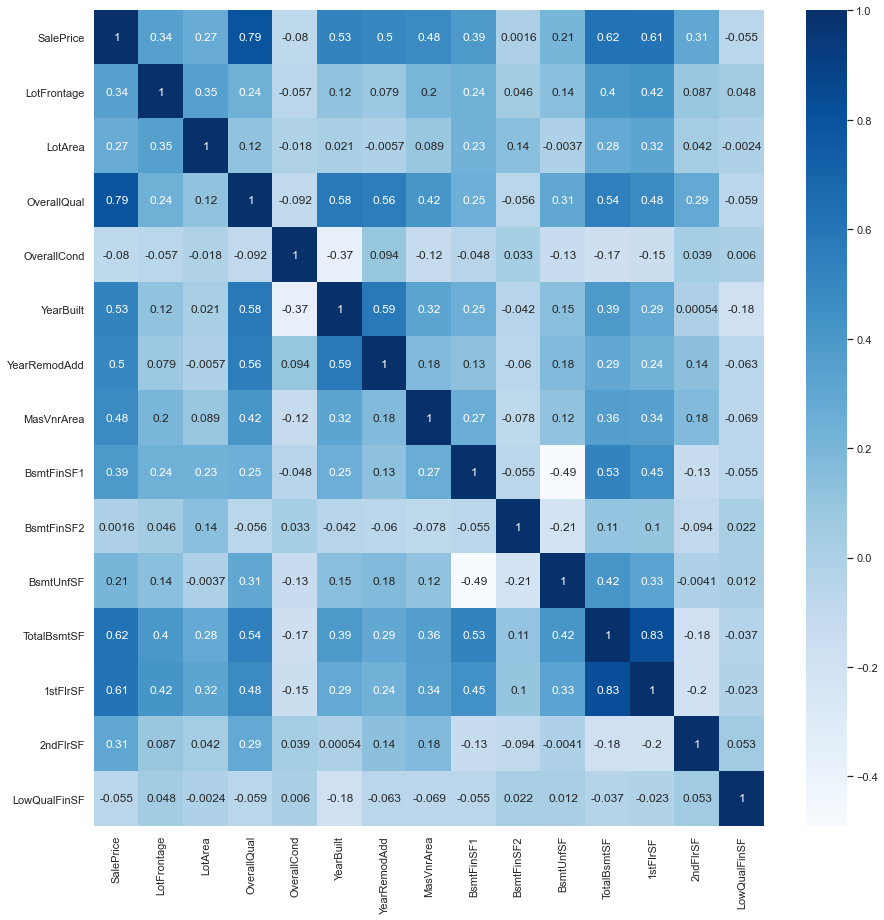

In [12]:
cor = pd.concat((y_train, X_train_enc),axis=1).iloc[:,:15].corr();
plt.figure(figsize=(15,15))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

- We can immediately see that `SalePrice` is highly correlated with `OverallQual`.
- This is an early hint that `OverallQual` is a useful feature in predicting `SalePrice`.
- However, this approach is **extremely simplistic**.
  - It only looks at each feature in isolation.
  - It only looks at linear associations:
    - What if `SalePrice` is high when `BsmtFullBath` is 2 or 3, but low when it's 0, 1, or 4? They might seem uncorrelated.

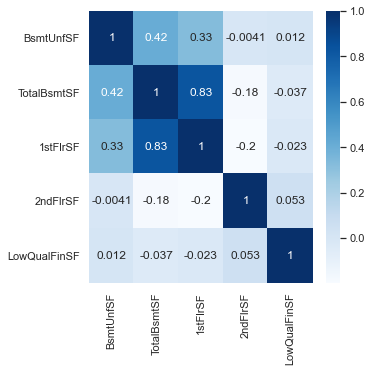

In [13]:
cor = pd.concat((y_train, X_train_enc),axis=1).iloc[:,10:15].corr();
plt.figure(figsize=(5,5))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

- Looking at this diagram also tells us the relationship between features. 
  - For example, `1stFlrSF` and `TotalBsmtSF` are highly correlated. 
  - Do we need both of them?
  - If our model says `1stFlrSF` is very important and `TotalBsmtSF` is very unimportant, do we trust those values?
  - Maybe `TotalBsmtSF` only "becomes important" if `1stFlrSF` is removed.
  - Sometimes the opposite happens: a feature only becomes important if another feature is _added_.

## 2. Feature importances in linear models 

- Video 2

- Like logistic regression, with linear regression we can look at the _coefficients_ for each feature.
- Overall idea: predicted price = intercept + $\sum_i$ coefficient i $\times$ feature i.

In [14]:
lr = make_pipeline(preprocessor, Ridge())
lr.fit(X_train, y_train);

Let's look at the coefficients. 

In [15]:
lr_coefs = pd.DataFrame(data=lr[1].coef_, index=new_columns, columns=["Coefficient"])
lr_coefs.head(20)

,Coefficient
LotFrontage,-2070.117618
LotArea,5234.852532
OverallQual,10685.771264
OverallCond,5002.438849
YearBuilt,3812.046289
YearRemodAdd,-121.940270
MasVnrArea,4774.591668
BsmtFinSF1,2860.636977
BsmtFinSF2,764.908753
BsmtUnfSF,-1396.722499


### Interpreting coefficients of different types of features. 

### Ordinal features

- The ordinal features are easiest to interpret. 

In [16]:
print(ordinal_features_reg)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']


In [17]:
lr_coefs.loc["ExterQual", 'Coefficient']

4308.238573360218

- "Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by \\$3845".
  - Wow, that's a lot! 

In [18]:
one_example = X_test[:1]

In [19]:
one_example['ExterQual']

147    Gd
Name: ExterQual, dtype: object

Let's perturb the example and change `ExterQual` to `Ex`. 

In [20]:
one_example_perturbed = one_example.copy()
one_example_perturbed["ExterQual"] = 'Ex' # Change Gd to Ex

In [21]:
one_example_perturbed

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


In [22]:
one_example_perturbed['ExterQual']

147    Ex
Name: ExterQual, dtype: object

How does the prediction change after changing `ExterQual` from `Gd` to `Ex`? 

In [23]:
print('Prediction on the original example: ', lr.predict(one_example))
print('Prediction on the perturbed example: ', lr.predict(one_example_perturbed))
print("After changing ExterQual from Gd to Ex increased the prediction by: ", lr.predict(one_example_perturbed) - lr.predict(one_example))

Prediction on the original example:  [219796.4328617]
Prediction on the perturbed example:  [228412.91000842]
After changing ExterQual from Gd to Ex increased the prediction by:  [8616.47714672]


That's exactly the learned coefficient for `ExterQual`! 

In [24]:
lr_coefs.loc["ExterQual", 'Coefficient']

4308.238573360218

So our interpretation is correct! 
- Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by \\$3845.

### Categorical features

- What about the categorical features?
- We have created a number of columns for each category with OHE and each category gets it's own coefficient. 

In [25]:
print(categorical_features)

['Exterior1st', 'GarageType', 'BldgType', 'MSSubClass', 'Heating', 'RoofMatl', 'Utilities', 'MoSold', 'Condition2', 'MSZoning', 'MasVnrType', 'KitchenAbvGr', 'Condition1', 'HouseStyle', 'GarageFinish', 'BedroomAbvGr', 'Electrical', 'Neighborhood', 'SaleCondition', 'Alley', 'LotConfig', 'Fence', 'BsmtFinType1', 'Foundation', 'PavedDrive', 'LandSlope', 'RoofStyle', 'MiscFeature', 'LandContour', 'SaleType', 'Exterior2nd', 'CentralAir', 'LotShape', 'BsmtExposure', 'Street', 'Functional', 'BsmtFinType2']


In [26]:
lr_coefs_landslope = lr_coefs[lr_coefs.index.str.startswith("LandSlope")]
lr_coefs_landslope

,Coefficient
LandSlope_Gtl,146.951190
LandSlope_Mod,7541.298231
LandSlope_Sev,-7688.249421


- We can talk about switching from one of these categories to another by picking a "reference" category:

In [27]:
lr_coefs_landslope - lr_coefs_landslope.loc["LandSlope_Gtl"]

,Coefficient
LandSlope_Gtl,0.000000
LandSlope_Mod,7394.347040
LandSlope_Sev,-7835.200611


- If you change the category from `LandSlope_Gtl` to `LandSlope_Mod` the prediction price goes up by $\sim\$7013$
- If you change the category from `LandSlope_Gtl` to `LandSlope_Sev` the prediction price goes down by $\sim\$8016$


Note that this might not make sense in the real world but this is what our model decided to learn given this small amount of data. 

Be a bit careful here: (optional)

- If you did `drop='first'` (we didn't) then you already have a reference class, and all the values are with respect to that one.
- The interpretation depends on whether we did `drop='first'`, hence the hassle.

### Interpreting coefficients of numeric features

Let's look at coefficients of `PoolArea` and `LotFrontage`. 

In [28]:
lr_coefs.loc[["PoolArea", "LotFrontage"]]

,Coefficient
PoolArea,2762.637722
LotFrontage,-2070.117618


Intuition: 

- **Increasing** `PoolArea` by 1 scaled unit **increases** the predicted price by $\sim\$3372$.
- **Increasing** `LotFrontage` by 1 scaled unit **decreases** the predicted price by $\sim\$1703$.

Does that sound reasonable?

- For `PoolArea`, yes. 
- For `LotFrontage`, that's surprising. Something positive would have made more sense?
- Do we believe these interpretations??
  - Do we believe this is how the predictions are being computed? Yes.
  - Do we believe that this is how the world works? No. 

It's not the case here but maybe the problem is that `LotFrontage` and `LotArea` are very correlated. `LotArea` has a larger positive coefficient. 

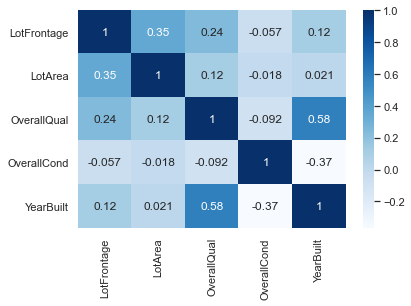

In [29]:
cor = X_train_enc[numeric_features[:5]].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

BTW, let's make sure the predictions behave as expected:

In [30]:
one_example = X_test[:1]

In [31]:
one_example

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


Let's perturb the example and add 1 to the `LotArea`. 

In [32]:
one_example_perturbed = one_example.copy()
one_example_perturbed["LotArea"] += 1 # add 1 to the LotArea

In [33]:
one_example_perturbed

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9506,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


Prediction on the original example. 

In [34]:
lr.predict(one_example)

array([219796.4328617])

Prediction on the perturbed example. 

In [35]:
lr.predict(one_example_perturbed)

array([219797.01486953])

- What's the difference between prediction? 
- Does the difference make sense given the coefficient of the feature? 

In [36]:
lr.predict(one_example_perturbed) - lr.predict(one_example)

array([0.58200783])

In [37]:
lr_coefs.loc[["LotArea"]]

,Coefficient
LotArea,5234.852532


- Why did the prediction only go up by \\$0.57 instead of \\$5134? 
- This is an issue of units. `LotArea` is in sqft, but the coefficient is not $\$5134/\text{sqft}$ **because we scaled the features**. 

### Example showing how can we interpret coefficients of scaled features. 

- The scaler subtracted the mean and divided by the standard deviation.
- The division actually changed the scale! 
- For the unit conversion, we don't care about the subtraction, but only the scaling.

In [38]:
scaler = preprocessor.named_transformers_['pipeline-1']['standardscaler']

In [39]:
np.sqrt(scaler.var_)

array([2.09591390e+01, 8.99447103e+03, 1.39208177e+00, 1.11242416e+00,
       3.01866337e+01, 2.06318985e+01, 1.77914527e+02, 4.59101890e+02,
       1.63890010e+02, 4.42869860e+02, 4.42817167e+02, 3.92172897e+02,
       4.35820743e+02, 4.69800920e+01, 5.29468070e+02, 5.18276015e-01,
       2.33809970e-01, 5.49298599e-01, 5.02279069e-01, 1.62604030e+00,
       6.34398801e-01, 2.40531598e+01, 7.40269201e-01, 2.10560601e+02,
       1.25388753e+02, 6.57325181e+01, 6.07432962e+01, 3.03088902e+01,
       5.38336322e+01, 4.23249944e+01, 5.22084645e+02, 1.33231649e+00])

In [40]:
lr_scales = pd.DataFrame(data=np.sqrt(scaler.var_), index=numeric_features, columns=["Scale"])
lr_scales.head()

,Scale
LotFrontage,20.959139
LotArea,8994.471032
OverallQual,1.392082
OverallCond,1.112424
YearBuilt,30.186634


You could also use `inverse_transform` to get this information. 

In [41]:
delta = scaler.inverse_transform(np.ones(len(numeric_features))) - scaler.inverse_transform(np.zeros(len(numeric_features)))
lr_scales = pd.DataFrame(data=delta, index=numeric_features, columns=["Scale"])
lr_scales.head()

,Scale
LotFrontage,20.959139
LotArea,8994.471032
OverallQual,1.392082
OverallCond,1.112424
YearBuilt,30.186634


- It seems like `LotArea` was divided by 8994.471032 sqft. 

In [42]:
lr_coefs.loc[["LotArea"]]

,Coefficient
LotArea,5234.852532


- The coefficient tells us that if we increase the `LotArea` by one unit the price would go up by \$5134. 
- One scaled unit represents 8994 sq feet. 

- So if I increase original `LotArea` by one square foot then the predicted price would go up by this amount: 

In [43]:
5134.590415/8994.471032 

0.570860742864417

- This makes much more sense. Now we get the number we got before. 
- That said don't read too much into these coefficients without statistical training. 

### Interim summary

- Correlation among features might make coefficients completely uninterpretable. 
- Fairly straightforward to interpret coefficients of ordinal features. 
- In categorical features, it's often helpful to consider one category as a reference point and think about relative importance. 
- For numeric features, relative importance is meaningful after scaling.
- You have to be careful about the scale of the feature when interpreting the coefficients. 

We will talk about features importances beyond linear models later in the course. 

## 2. Feature selection: Introduction and motivation 

### What is feature selection?

- Find the features	(columns) $X$ that are important for predicting	$y$, and remove the features that aren't. 

- Given $X = \begin{bmatrix}x_1 & x_2 & \dots & x_n\\  \\  \\  \end{bmatrix}$ and $y = \begin{bmatrix}\\  \\  \\  \end{bmatrix}$, find the columns $1 \leq j \leq n$ in $X$ that are important for predicting $y$.


In [44]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Which of these features are useful?

### Why feature selection? 

- Interpretability: Models are more interpretable with fewer features. If you get the same performance with 10 features instead of 500 features, why not use the model with smaller number of features?     
- Computation: Models fit/predict faster with fewer columns.
- Data collection: What type of new data should I collect? It may be cheaper to collect fewer columns.
- Fundamental tradeoff: Can I reduce overfitting by removing useless features?

Feature selection can often result in better performing (less overfit), easier to understand, and faster model. 


### How do we carry out feature selection? 

- You could use domain knowledge to discard features. 
- Very related to looking at feature importances.

We are going to look into three methods: 

1. This lecture
    - Recursive feature elimination
    - Forward selection 
2. Coming up: we'll talk about one more useful approach (Lasso). 

## 3 . Recursive feature elimination 

- Let's use feature importances to eliminate unimportant features. 
- Basic idea
    - fit model
    - find least important feature
    - remove
    - iterate.

### Recursive feature elimination 

1. Decide $k$, the number of features to select. 
2. Assign importances to features, e.g. by fitting a model and looking at `coef_` or `feature_importances_`.
3. Remove the least important feature.
4. Repeat steps 2-3 until only $k$ features are remaining.

Note that this is **not** the same as just removing all the less important features in one shot!


In scikit-learn, we'll do this using `RFE`. 
Before trying `RFE`, let's look at cross-validation results with all features. 

In [45]:
X_train_enc.head(10)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Functional_Min2,Functional_Mod,Functional_Typ,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_missing
302,2.312501,0.381428,0.663680,-0.512408,0.993969,0.840492,0.269972,-0.961498,-0.287191,2.197106,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
767,0.260890,0.248457,-0.054669,1.285467,-1.026793,0.016525,-0.573129,0.476092,-0.287191,-0.553138,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
429,2.885044,0.131607,-0.054669,-0.512408,0.563314,0.161931,-0.573129,1.227559,-0.287191,-0.408626,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1139,1.358264,-0.171468,-0.773017,-0.512408,-1.689338,-1.679877,-0.573129,0.443419,-0.287191,-0.672812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
558,-0.597924,1.289541,0.663680,-0.512408,0.828332,0.598149,-0.573129,0.354114,-0.287191,-1.000222,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
761,-0.454788,-0.373814,-0.773017,-0.512408,-1.556829,-1.679877,-0.573129,-0.079341,-0.287191,0.388448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1046,0.738009,0.642922,2.100377,-0.512408,1.126478,1.034366,0.595971,-0.438738,-0.287191,2.673544,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1265,-1.647585,-0.726920,0.663680,-0.512408,0.927714,0.695086,0.652178,0.018677,-0.287191,-0.738294,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1187,0.928857,0.243232,1.382028,-0.512408,0.762078,0.501211,-0.573129,2.209912,-0.287191,-0.903128,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
783,-0.025381,-0.130331,-0.773017,0.386530,0.232042,-0.322755,0.011421,1.427950,-0.287191,-1.282472,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
results = {}

In [47]:
lr = RidgeCV()
results['RidgeCV'] = pd.DataFrame(cross_validate(lr, X_train_enc, y_train, return_train_score=True)).mean()

In [48]:
pd.DataFrame(results)

,RidgeCV
fit_time,0.109436
score_time,0.003238
test_score,0.797017
train_score,0.902361


In [49]:
lr.fit(X_train_enc, y_train)
coef_df = pd.DataFrame(data=np.abs(lr.coef_), index=X_train_enc.columns, columns=["Coefficients"]).sort_values(by="Coefficients", ascending=False)
coef_df.head(10)

,Coefficients
RoofMatl_ClyTile,29347.131724
Neighborhood_StoneBr,26855.091566
Neighborhood_NoRidge,26380.545613
Neighborhood_NridgHt,24663.193767
PoolQC,23562.475795
Condition2_PosN,23357.438234
RoofMatl_WdShngl,21634.503296
Neighborhood_Edwards,15042.578578
BsmtExposure_Gd,14757.810723
LotShape_IR3,13286.391824


Let's try `RFE` and score the model. 

- Let's set number of features to 30. 
- `RFE` will select the top 30 features, one at a time, based on the absolute value of `model.coef_`:

In [50]:
from sklearn.feature_selection import RFE, RFECV

rfe = RFE(Ridge(), n_features_to_select=30)

In [51]:
results['RFE with 30 feats'] = pd.DataFrame(cross_validate(rfe, X_train_enc, y_train, return_train_score=True)).mean()
pd.DataFrame(results)

,RidgeCV,RFE with 30 feats
fit_time,0.109436,0.525119
score_time,0.003238,0.003164
test_score,0.797017,0.739485
train_score,0.902361,0.848590


Let's look at selected features. 

In [52]:
rfe.fit(X_train_enc, y_train)
selected_columns = X_train_enc.columns[rfe.support_]
selected_columns

Index(['OverallQual', '1stFlrSF', '2ndFlrSF', 'PoolQC', 'Exterior1st_AsphShn',
       'Exterior1st_ImStucc', 'MSSubClass_160', 'Heating_OthW',
       'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Roll',
       'RoofMatl_WdShngl', 'Condition2_PosN', 'MSZoning_C (all)',
       'MSZoning_FV', 'KitchenAbvGr_1', 'KitchenAbvGr_3', 'BedroomAbvGr_0',
       'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_StoneBr', 'SaleCondition_Family', 'RoofStyle_Flat',
       'LandContour_Bnk', 'SaleType_Con', 'SaleType_New',
       'Exterior2nd_ImStucc', 'BsmtExposure_Gd', 'Functional_Typ'],
      dtype='object')

Contrast with the top 30 by the ORIGINAL importances (absolute value coefficients):

In [53]:
coef_df.iloc[:30].index

Index(['RoofMatl_ClyTile', 'Neighborhood_StoneBr', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'PoolQC', 'Condition2_PosN', 'RoofMatl_WdShngl',
       'Neighborhood_Edwards', 'BsmtExposure_Gd', 'LotShape_IR3', 'GrLivArea',
       'OverallQual', 'Neighborhood_Gilbert', 'Neighborhood_Mitchel',
       'Exterior2nd_ImStucc', 'Neighborhood_Timber', 'BldgType_1Fam',
       'BedroomAbvGr_5', 'Exterior1st_BrkFace', 'Neighborhood_Crawfor',
       '2ndFlrSF', 'Condition1_Norm', 'MSZoning_C (all)', 'HouseStyle_1Story',
       'BldgType_Twnhs', 'GarageCars', 'Exterior2nd_Stucco', 'BsmtQual',
       'LandContour_Bnk', 'Functional_Typ'],
      dtype='object')

In [54]:
set(selected_columns.values) - set(coef_df.iloc[:30].index.values)

{'1stFlrSF',
 'BedroomAbvGr_0',
 'Exterior1st_AsphShn',
 'Exterior1st_ImStucc',
 'Heating_OthW',
 'KitchenAbvGr_1',
 'KitchenAbvGr_3',
 'MSSubClass_160',
 'MSZoning_FV',
 'RoofMatl_CompShg',
 'RoofMatl_Roll',
 'RoofStyle_Flat',
 'SaleCondition_Family',
 'SaleType_Con',
 'SaleType_New'}

How many features are selected? 

In [55]:
rfe.n_features_

30

- Ranking based on feature importances.  
- Selected features are assigned rank 1.

In [56]:
rfe.ranking_ # may be different than the ranked feature importances!

array([175,  95,   1,  70,  77, 260, 121, 209, 233,  45,  47,   1,   1,
       217,  34, 183, 252, 182, 187, 114, 166, 235,  35, 268, 212, 262,
       249, 200, 190, 171, 253, 234, 127, 179,   6, 267, 248,  23, 255,
       136, 266,   1, 157,   1, 189,  12, 174,  13, 142,   1, 156, 226,
       181, 176, 264, 196, 225, 131, 221, 122, 145, 138, 245,  36, 162,
       107, 165,  64,  71,  99,  98, 250, 164,  80, 102, 101, 151,  53,
       213, 184,   3,   1,   5, 108, 178,  84,  63, 238,   1,  69,   1,
         1,  19,  41,   1,  46,  20,   1,  15,  10, 241, 116, 216, 230,
       152, 240, 153,  90, 224,  52, 239, 195,   2,  49,  33,   8,   1,
        93,  44,  22,   1,   1, 126, 125, 202, 120, 119, 180, 215, 214,
         1, 139,   1, 161, 160,  26,  57, 211,   7,  25, 199,  56, 141,
        43,  28,   4,  87, 103, 256, 172, 220, 148, 149, 150,   1, 112,
       243,  85, 115,  29, 113, 123, 134, 133,  17, 135, 132, 194, 219,
       227,  31, 242,  78,  74,   1,  16,  73,  62,  14,  60,  6

What about categorical features?

In [57]:
selected_columns = X_train_enc.columns[rfe.support_]
selected_columns.values

array(['OverallQual', '1stFlrSF', '2ndFlrSF', 'PoolQC',
       'Exterior1st_AsphShn', 'Exterior1st_ImStucc', 'MSSubClass_160',
       'Heating_OthW', 'RoofMatl_ClyTile', 'RoofMatl_CompShg',
       'RoofMatl_Roll', 'RoofMatl_WdShngl', 'Condition2_PosN',
       'MSZoning_C (all)', 'MSZoning_FV', 'KitchenAbvGr_1',
       'KitchenAbvGr_3', 'BedroomAbvGr_0', 'Neighborhood_Crawfor',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_StoneBr', 'SaleCondition_Family', 'RoofStyle_Flat',
       'LandContour_Bnk', 'SaleType_Con', 'SaleType_New',
       'Exterior2nd_ImStucc', 'BsmtExposure_Gd', 'Functional_Typ'],
      dtype=object)

In [58]:
removed_columns = [col for col in X_train_enc.columns if col not in selected_columns]
removed_columns

['LotFrontage',
 'LotArea',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'YrSold',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'Exterior1st_AsbShng',
 'Exterior1st_BrkComm',
 'Exterior1st_BrkFace',
 'Exterior1st_CBlock',
 'Exterior1st_CemntBd',
 'Exterior1st_HdBoard',
 'Exterior1st_MetalSd',
 'Exterior1st_Plywood',
 'Exterior1st_Stone',
 'Exterior1st_Stucco',
 'Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng',
 'Exterior1st_WdShing',
 'GarageType_2Types',
 'GarageType_Attchd',
 'GarageType_Basment',
 'GarageType_BuiltIn',
 'GarageType_CarPort',
 'GarageType_De

- Does it make sense that we removed `BldgType_Duplex` but kept `BldgType_1Fam`?
  - This is a matter of opinion, I guess.
- There are more sophisticated ways of selecting categorical features.
- This seems to be unresolved in sklearn: https://github.com/scikit-learn/scikit-learn/issues/8480

#### (optional) Feature selection and OHE

- If you are using OHE with `drop='first'`, and then feature selection, the choice to drop the first is no longer arbitrary.
  - Say you have categories A,B,C,D
  - you drop='first'
  - so then you have B,C,D and 0,0,0 means A.
  - Then you feature select out D
  - Now you have B,C
  - but now 0,0 means A or D.
  - So now the feature removed by feature selection becomes mixed up with the "arbitrary" feature A.

### How to choose the number of features to select?

- Suppose you don't know the number of relevant features in advance, 
- You can find them using cross validation with [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV)
  - You would definitely not want to use training error! (Why?)

In [59]:
rfe_cv = RFECV(Ridge(), cv=10)
rfe_cv.fit(X_train_enc, y_train)
print('Number of selected features: %d/%d' % (rfe_cv.n_features_, X_train_enc.shape[1]))

Number of selected features: 80/297


- It stopped once it got to 80 features.
- Dropping down to 79 would lower the cross-validation score.
  - This is similar to using cross-validation to tune a hyperparameter.
  - Indeed, the number of selected features _is_ a hyperparameter.

We are violating the Golden Rule a bit here. Can we incorporate this in a pipeline? 

In [60]:
from sklearn.linear_model import RidgeCV

pipe_rfe_ridgecv = make_pipeline(preprocessor, RFECV(Ridge(), cv=10), RidgeCV())
results['pipe RFECV + RidgeCV'] = pd.DataFrame(cross_validate(pipe_rfe_ridgecv, X_train, y_train, return_train_score=True)).mean()


In [61]:
pd.DataFrame(results)

,RidgeCV,RFE with 30 feats,pipe RFECV + RidgeCV
fit_time,0.109436,0.525119,6.718892
score_time,0.003238,0.003164,0.011943
test_score,0.797017,0.739485,0.787224
train_score,0.902361,0.848590,0.898362


In [62]:
pipe_rfe_ridgecv.fit(X_train,y_train)
print(pipe_rfe_ridgecv.named_steps["rfecv"].support_)
print(
    "The number of features selected by RFE: ",
    pipe_rfe_ridgecv.named_steps["rfecv"].n_features_,
)

[False False  True False False False False False False  True  True  True
  True False  True False False False False False False False  True False
 False False False False False False False False False False  True False
 False  True False False False  True False  True False  True False  True
 False  True False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False  True  True  True False
 False False False False  True False  True  True  True  True  True  True
  True  True  True  True False False False False False False False False
 False False False False  True  True  True  True  True False  True  True
  True  True False False False False False False False False  True False
  True False False  True False False  True  True False False False  True
  True  True False False False False False False False False  True False
 False False False  True False False False False  T

### How do we get feature names of selected features? 

In [70]:
feature_names = X_train_enc.columns
support = pipe_rfe_ridgecv.named_steps["rfecv"].support_
RFE_selected_feats = np.array(feature_names)[support]
RFE_selected_feats

array(['OverallQual', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'GarageCars', 'BsmtQual', 'KitchenQual', 'PoolQC',
       'Exterior1st_AsphShn', 'Exterior1st_BrkFace',
       'Exterior1st_CemntBd', 'Exterior1st_ImStucc', 'GarageType_missing',
       'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_180',
       'Heating_OthW', 'RoofMatl_ClyTile', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'Utilities_AllPub', 'Utilities_NoSeWa', 'Condition2_Artery',
       'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA',
       'Condition2_PosN', 'Condition2_RRAn', 'Condition2_RRNn',
       'MSZoning_C (all)', 'MSZoning_FV', 'KitchenAbvGr_1',
       'KitchenAbvGr_3', 'Condition1_Norm', 'Condition1_RRAe',
       'Condition1_RRAn', 'HouseStyle_1.5Unf', 'HouseStyle_1Story',
       'HouseStyle_2.5Fin', 'BedroomAbvGr_0', 'BedroomAbvGr_5',
       'Electrical_Fus

### RFE for classification 

In [71]:
# Let's try RFE on the spotify dataset
# You can get the dataset from here: https://www.kaggle.com/geomack/spotifyclassification/
spotify_df = pd.read_csv("data/spotify.csv")
spotify_df.columns

numcols = [
    "acousticness",
    "danceability",
    "duration_ms",
    "energy",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "time_signature",
    "valence",
    "target",
]
catcols = ["song_title", "artist", "Unnamed: 0"]

spotify_df = spotify_df.drop(columns=catcols)
spotify_df.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target'],
      dtype='object')

In [72]:
# Create train/test splits
X = spotify_df.drop(columns=["target"])
y = spotify_df["target"]
X_train_spo, X_test_spo, y_train_spo, y_test_spo = train_test_split(
    X, y, test_size=0.2, random_state=111
)

In [73]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=123))

In [74]:
lr = LogisticRegression(solver="liblinear")
pipe_rfe = make_pipeline(StandardScaler(), RFECV(estimator=lr), LogisticRegression(random_state=123))

In [75]:
scores = cross_validate(pipe, X_train_spo, y_train_spo, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       0.008807
score_time     0.001743
test_score     0.663387
train_score    0.671884
dtype: float64

In [76]:
scores = cross_validate(pipe_rfe, X_train_spo, y_train_spo, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       0.118094
score_time     0.001776
test_score     0.657804
train_score    0.674675
dtype: float64

## 2. Search and score method (e.g., forward selection)

### General idea of search and score methods 

- Define a **scoring function** $f(S)$ that measures the quality of the set of features $S$. 
- Now **search** for the set of features $S$ with the best score.

- Example: Suppose you have three features: $A, B, C$
    - Compute **score** for $S = \{\}$
    - Compute **score** for $S = \{A\}$
    - Compute **score** for $S= \{B\}$
    - Compute **score** for $S = \{C\}$
    - Compute **score** for $S = \{A,B\}$    
    - Compute **score** for $S = \{A,C\}$
    - Compute **score** for $S = \{B,C\}$
    - Compute **score** for $S = \{A,B,C\}$    
- Return $S$ with the best score.  
- How many distinct combinations we have to try out? 

### Search and **score**: What scoring function should we use? 
- How do we measure the quality of the set of features $S$? 

- Pick a metric. 
- Find the set of features that gives you the best cross-validation scores with that metric. 
- Picking features set based on the training error would be a bad idea. 

### Problems with search and score methods 
- If there are $d$ features, there are $2^d$ combinations to search.
    - For example, if $d=100$, we have $1.26 \times 10^{30}$ combinations to search
- Large search space.     
- Optimization bias is high: we are optimizing over $2^d$ models!    
- Irrelevant variables sometimes help by chance. Prone to overfitting.  

How do we deal with these problems? 

- How can we deal with the large search space? 
    - Instead of exhaustively searching for this space, we go with greedy approaches. No guarantee to find optimal feature set.  
- How can we pick a model that's less likely to overfit?     
    - Adding complexity penalty

### Model selection: complexity penalty 

- In search and score methods, to reduce overfitting, we can use complexity penalties, i.e., we can penalize complex models. 
- So far we have been doing model selection using cross validation. 
- Another way to select a model is based on complexity
    - penalize complex models 
    - complexity in terms of the number of degrees of freedom or parameters in the model
    

$$ score(p) = \frac{1}{2}\lVert{Z_pv -y}\rVert^2 + \lambda k$$

- $p \rightarrow$  degree of polynomial in polynomial transformations
- $k \rightarrow \text{estimated parameters/degrees of freedom}$
    
- $\lambda \rightarrow \text{penalization factor}$

Pick the model with lowest score.    

### Scoring using complexity penalties

- You can think of features with non-zero weights as selected features.
- Find $S$ and $W_s$ minimizing the squared error + the number of selected features 

$$ score(S) = \frac{1}{2}\sum_i^n(w_s^TX_{iS} -y_i)^2 + size(S)$$

- $X_{iS}$ is features $S$ of example $X_i$. 
- Example: Suppose $S_1 = \{x_1, x_2, x_4\}$ $S_2 = \{x_1, x_2, x_4, x_5\}$ have similar validation errors, it prefers $S_1$.
- Instead of $size(S)$, we usually write $L0$ "norm"

### $L0$ "norm"  and the number of features used

- In linear models, setting $w_j = 0$ is the same as removing the feature.
- Example: $$\hat{y_i} = w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4$$
- $L0$ "norm" is the number of non-zero values.  
- If $w = \begin{bmatrix}0.8 \\ 0.0 \\ 0.03 \\0.1\end{bmatrix}$, $\lVert w\rVert_0 = 3$ and if $w = \begin{bmatrix}0.0 \\ 0.0 \\ 0.22 \\0.0\end{bmatrix}$, $\lVert w\rVert_0 = 1$


### Scoring using $L0$ "norm" 


- Most common "scores" have the form.

$$ score(S) = \frac{1}{2}\lVert{Xw -y}\rVert^2 + \lambda \lVert w\rVert_0$$

- $\lambda \rightarrow \text{penalization factor (strength of penalty) }$

- $ \lVert w\rVert_0 \rightarrow$ Number of non-zero elements in $w$ (i.e., number of features used)
- To increase the degrees of freedom by one, need to decrease the error by $\lambda$. 
- Prefer smaller degrees of freedom if errors are similar. 
- Can't optimize because the function is discontinuous in $\lVert w\rVert_0$
    - Search over possible models 

### Forward selection: greedy approach for search and score 

Given $X = \{x_1, x_2, \dots, x_n\}$ and $y$

1. Start with an empty set of features $S = \{\}$ 
2. Initialize the score (e.g., score = $\infty$, if score is validation error)
3. For each possible feature $x_j, 1\leq j \leq n$ 
    - Compute the scores of features in $S$ combined with $x_j$
4. If no $x_j$ improves the score, stop. 
5. Otherwise add feature $x_j$ to $S$ which improves the score the most, update the score, and go back to step 2. 

### Forward selection: Example

- Not implemented in `sklearn`! (There is an optional question in lab 2 which asks you to implement it.)

<img src='imgs/forward_selection.png' width="1000" height="1000" />

Forward selection is not implemented in `sklearn`. But it is in a package `mlxtend`, which is compatible with `sklearn` pipelines. 

You can install `mlxtend` in our environment as follows: 
```
conda install -c conda-forge mlxtend
```

In [77]:
from mlxtend.feature_selection import SequentialFeatureSelector

In [78]:
sfs = SequentialFeatureSelector(Ridge(), forward=True, k_features=7)

In [79]:
pipe_forward_ridgecv = make_pipeline(
    preprocessor, 
    SequentialFeatureSelector(Ridge(), forward=True, k_features=20),
    RidgeCV(),
)

scores = cross_validate(pipe_forward_ridgecv, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       32.374404
score_time      0.011726
test_score      0.791236
train_score     0.872936
dtype: float64

### How to get feature names of selected features? 

In [82]:
pipe_forward_ridgecv.fit(X_train, y_train)

In [88]:
feature_names = X_train_enc.columns
fs_selected_feats = [feature_names[i] for i in pipe_forward_ridgecv.named_steps["sequentialfeatureselector"].k_feature_idx_]
fs_selected_feats

['LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'GrLivArea',
 'GarageCars',
 'BsmtQual',
 'KitchenQual',
 'Exterior1st_BrkFace',
 'BldgType_1Fam',
 'MSSubClass_20',
 'Condition1_Norm',
 'GarageFinish_Fin',
 'Neighborhood_Crawfor',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'BsmtFinType1_Unf',
 'BsmtExposure_Gd']

### Forward selection

- Not guaranteed to find the best feature set but reduces many problems
    - Cheaper (considers only $O(d^2)$ models compared to $O(2^d)$ models) 
    - Overfits less (less optimization bias)    

### Other ways to search 

- Backward selection
- Stochastic local search
    - Inject randomness so that we can explore new parts of the search space
    - Simulated annealing
    - Genetic algorithms

### Warnings about feature selection 

- A feature's relevance is only defined in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- If features can be predicted from other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$ for the data you have.

#### Problems with feature selection (optional)

- The term 'relevance' is not clearly defined.
- What all things can go wrong with feature selection?

#### Example: Is "Relevance" clearly defined?

- Consider a supervised classification task of predicting whether someone has particular genetic variation (SNP)
<img src='imgs/sex_mom_dad.png' width="600" height="600" />

- True model: You almost have the same value as your biological mom.

#### Is "Relevance" clearly defined?

- True model: You almost have the same value for SNP as your biological mom.
    - (SNP = biological mom) with very high probability 
    - (SNP != biological mom) with very low probability 


<img src='imgs/SNP.png' width="200" height="200" />


#### Is "Relevance" clearly defined?

- What if "mom" feature is repeated?
- Should we pick both? Should we pick one of them because it predicts the other? 
- Dependence, collinearity for linear models
    - If a feature can be predicted from the other, don't know which one to pick. 

<img src='imgs/sex_mom_mom2_dad.png' width="600" height="600" />


#### Is "Relevance" clearly defined?

- What if we add (maternal) "grandma" feature?
- Is it relevant? 
    - We can predict SNP accurately using this feature
- Conditional independence
    - But grandma is irrelevant given biological mom feature
    - Relevant features may become irrelevant given other features

<img src='imgs/sex_mom_dad_grandma.png' width="600" height="600" />


#### Is "Relevance" clearly defined?

- What if we do not know biological mom feature and we just have grandma feature
- It becomes relevant now. 
    - Without mom feature this is the best we can do. 
- General problem ("taco Tuesday" problem)
    - Features can become relevant due to missing information 


<img src='imgs/sex_dad_grandma.png' width="600" height="600" />


#### Is "Relevance" clearly defined?

- Are there any relevant features now?
- They may have some common maternal ancestor.   
- What if mom likes dad because they share SNP? 
- General problem (Confounding)
    - Hidden features can make irrelevant features relevant.

<img src='imgs/sex_dad.png' width="600" height="600" />


#### Is "Relevance" clearly defined?

- Now what if we have "sibling" feature? 
- The feature is relevant in predicting SNP but not the cause of SNP. 
- General problem (non causality)
    - the relevant feature may not be causal 

<img src='imgs/sex_dad_sibling.png' width="600" height="600" />


#### Is "Relevance" clearly defined?

- What if you are given "baby" feature?
- Now the sex feature becomes relevant. 
    - "baby" feature is relevant when sex == F
    
- General problem (context specific relevance)
    - adding a feature can make an irrelevant feature relevant

<img src='imgs/sex_dad_baby.png' width="600" height="600" />


#### Warnings about feature selection 

- A feature is only relevant in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- Confounding factors can make irrelevant features the most relevant.
- If features can be predicted from other other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 

- Is feature selection completely hopeless?
    - It is messy but we still need to do it. So we try to do our best! 

#### General advice on finding relevant features

- Try the association approach
- Try forward selection with different values of $\lambda$
- Try other feature selection methods (e.g., `RFE`, simulated annealing, genetic algorithms)
- Talk to domain experts; they probably have an idea why certain features are relevant.
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$.

#### Summary

- Recursive feature elimination (RFE)
    - Fit parameters of a linear model.
    - Prune features with small weights.
    - Repeat till we reach the number of required features.
- Most common approach for feature selection is **search** and **score**. 
- It's hard to define "score" and it's hard to "search". 
- Most common "scores" have the form of $\lVert L_0\rVert$ "norm"

$$ score(S) = \frac{1}{2}\lVert{Xw -y}\rVert^2 + \lambda \lVert w\rVert_0$$

- For "search", we use greedy methods such as forward search. 
- Methods work well on toy data but could be frustrating on real data. 
    - different methods may return very different results

#### A rough guide to feature selection (bonus slide)

<img src='imgs/feature_selection_guidelines.png' width="1000" height="1000" />

Source: Mark Schmidt's slides from last year

#### Relevant resources 
- [Genome-wide association study](https://en.wikipedia.org/wiki/Genome-wide_association_study)
- [sklearn feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)
- [PyData: A Practical Guide to Dimensionality Reduction Techniques](https://www.youtube.com/watch?v=ioXKxulmwVQ)

### True/False questions: Feature selection (Class discussion)

1. Simple association-based feature selection approaches do not take into account the interaction between features.<br>
2. You can carry out feature selection using linear models by pruning the features which have very small weights (i.e., coefficients less than a threshold).<br>
3. Forward search is guaranteed to find the best feature set.<br>  
4. A scoring function in score and search methods can be written as follows. $$ score(S) = \frac{1}{2}\lVert{Xw -y}\rVert^2 + \lambda \lVert w\rVert_0$$
Here smaller $\lVert w\rVert_0$ means we discard most of the features. 
5. In the above equation, larger $\lambda$ means aggressive feature pruning. 
6. The order of features removed given by `rfe.ranking_` is the same as the order of original feature importances given by a regression model.  
<br><br><br><br><br><br><br><br><br>